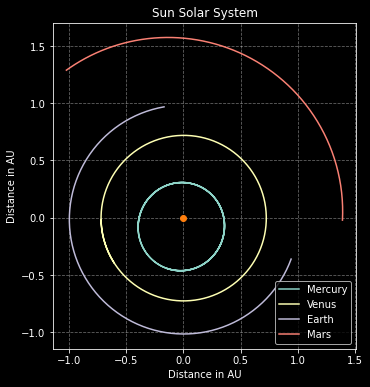

In [1]:
# object oriented sun earth simulation
#%%
import numpy as np
# import pandas as pd
import spiceypy
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import datetime
import matplotlib.animation as animation
# from astroquery.jplhorizons import Horizons
from IPython.display import HTML
from IPython.display import display
import ipywidgets as widgets

spiceypy.furnsh("../_kernels/pck/gm_de431.tpc")
spiceypy.furnsh("../_kernels/lsk/naif0012.tls")
spiceypy.furnsh("../_kernels/spk/de432s.bsp")
# consts
start_date_utc = datetime.datetime(year=2000, month=1, day=1)
end_date_utc = datetime.datetime(year=2000, month=9, day=1)
start_date_et = spiceypy.utc2et(start_date_utc.strftime("%Y-%m-%dT00:00:00"))
end_date_et = spiceypy.utc2et(end_date_utc.strftime("%Y-%m-%dT00:00:00"))

year = 365*86400                            # sec in year [s]
au = 1.49598e11                             # AU in m     [m]
duration = (end_date_utc-start_date_utc).days*86400
t0 = 0.
nt = int(np.round(duration/86400,0))
t = np.linspace(t0,duration,nt)
legend_objects = []
legend_titles = []

class Planet:

    data_skip = 1

    def __init__(self, naifid, name, orbiting):
        self.name = name
        self.barrycenter_id = int(str(naifid)[0])
        self.state, self.r_sun = spiceypy.spkgeo(targ=self.barrycenter_id, et=start_date_et, \
                                    ref="ECLIPJ2000", obs=10)
        self.state = self.state*1000                        # km -> m
        self.parent = orbiting
        self.y = []
        self.line = []
        orbiting.add_planet(self)
    
    def f(self, y, t, mstar):
        self.gm = solar_system.G*mstar
        self.x = y[0:3]
        self.v = y[3:]
        self.r = np.linalg.norm(self.x)
        self.dxdt = self.v
        self.dvdt = -self.gm*self.x/self.r**3
        self.dy = np.hstack((self.dxdt, self.dvdt))
        return self.dy
    
    def plot_orbit_2d(self):
        y = self.calculate_orbit()                      
        self.y = y
        self.line, = space_map_ax.plot(y[:,0],y[:,1])
        self.line.set_label(self.name)
        legend_objects.append(self.line)
        legend_titles.append(self.name)
        return self.line, self.y

    def calculate_orbit(self):
        y = odeint(self.f, self.state,t, args=(self.parent.sun_mass,))
        y = y/au                                        # divide by AU 
        return y
    
    def animate_orbit(self):
        for i in range(len(self.y)):
            space_map_anim[0].plot(self.y[i:i+Planet.data_skip,0]/au, \
                self.y[i:i+Planet.data_skip,1]/au, "o", color="blue")


    @classmethod
    def from_string(cls, planet_str):
        id, name, orbiting = planet_str.split('-')
        return cls(id, name, orbiting)

    
class solar_system:

    G = 6.67428e-11                             # m3 / kg / s^2
    def __init__(self, name, sun_mass):
        self.name = name
        self.sun_mass = sun_mass
        self.planets = []
        self.ax = []
        self.fig = []

    
    def add_planet(self, planet):
        self.planets.append(planet)

    def create_space_map(self):
        plt.style.use("dark_background")
        fig, ax = plt.subplots(figsize=(8,6))
        ax.grid(linestyle="dashed", alpha=0.4)
        ax.set_title(self.name + " Solar System")
        ax.plot([0.],[0.],'o', color="tab:orange")
        ax.set_aspect("equal")
        ax.set_ylabel("Distance in AU")
        ax.set_xlabel("Distance in AU")
        return ax, fig
    
    def populate_ss(self):
        for i in self.planets:
            i.plot_orbit_2d()


# Let's add our solar system as an instance

Sun = solar_system("Sun", 1.98892e30)

# create our solar system and save Axes object as space_map
space_map_ax, space_map_fig = Sun.create_space_map()


mercury = Planet(199, "Mercury", Sun)
venus = Planet(299, "Venus", Sun)
earth = Planet(399, "Earth", Sun)
mars = Planet(499, "Mars", Sun)
# jupiter = Planet(599, "Jupiter", Sun)
# saturn = Planet(699, "Saturn", Sun)
# uranus = Planet(799, "Uranus", Sun)
# neptune = Planet(899, "Neptune", Sun)

Sun.populate_ss()

space_map_ax.legend(legend_objects, legend_titles)
# plt.savefig("hei.png")
plt.show()
plt.close('all')

# space_map_anim = Sun.create_space_map()
# anim = animation.FuncAnimation(space_map_anim[1], earth.animate_orbit(),  \
#             frames=duration, interval=200)
# anim.save('ani.mp4',writer='ffmpeg',fps=1000/50)


#%%

# kind of functioning. Here we have no animation, but no errors either...

# fig = plt.figure(2)
# ax = plt.axes(xlim=(0, 1), ylim=(0, 1))
# scat = ax.scatter([], [], s=60)

# def init():
#     scat.set_offsets([])
#     return scat,

# def animate(i):
#     data = [earth.y[i,0], earth.y[i,1]]
#     scat.set_offsets(data)
#     return scat,

# anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(earth.y), 
#                                interval=20, blit=False, repeat=False)

# anim.save('animation.mp4')




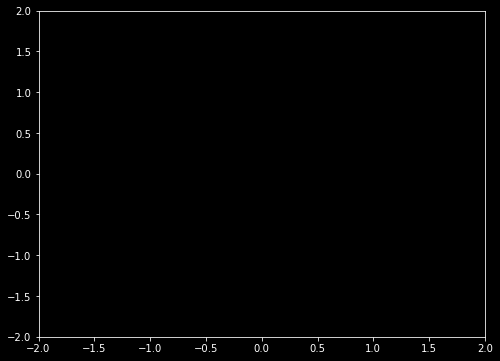

In [2]:
#%%
def update_plot(i, data, scat):
    scat.set_offsets(data[i,:])
    return scat,

numframes = len(earth.y)
x = earth.y[:,0]
y = earth.y[:,1]
data = []
data = np.hstack((x[:,np.newaxis], y[:, np.newaxis]))

fig, ax = plt.subplots(figsize=(8,6))
scat = ax.scatter([], [])
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])

ani = animation.FuncAnimation(fig, update_plot, frames=numframes-1,\
    # interval=int(np.round(numframes/25,0)+1), fargs=(data, scat))
    interval=15, fargs=(data, scat))

plt.show()
HTML(ani.to_html5_video())
# ani.save("hei.mp4")

